In [1]:
import os
import pickle 
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
input_dir='/kaggle/input/flickr8k'
output_dir='/kaggle/working'

Importing the VGG model without the last layer

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Extracting features using VGG model

In [4]:
features = {}
directory=os.path.join(input_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
#For dumping
pickle.dump(features,open(os.path.join(output_dir,'features.pkl'),'wb'))

#For loading
# with open(os.path.join(output_dir,'features.pkl'),'rb') as f:
#     features=pickle.load(f)

## Loading Captions


In [6]:
with open(os.path.join(input_dir,'captions.txt'),'r') as f:
    next(f)
    captions=f.read() 

In [7]:
imgcap_map = dict()
for caption in captions.split('\n'):
    tokens=caption.split(',')
    if(np.shape(tokens)[0])<2:
        continue
    image_id=tokens[0]
    image_caption=" ".join(tokens[1:])
    image_id=image_id.split('.')[0]

    if image_id not in imgcap_map:
        imgcap_map[image_id]=[]
    imgcap_map[image_id].append(image_caption)

In [8]:
len(imgcap_map)

8091

## Preprocess Text Data

In [9]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^a-z]','')
            caption=caption.replace('\s+',' ')
            caption = 'startseq ' +" ".join([word for word in caption.split() if len(word)>1])+ ' endseq'
            captions[i]=caption

In [10]:
clean(imgcap_map)
all_captions=[]
for key in imgcap_map:
    for caption in imgcap_map[key]:
        all_captions.append(caption)

In [11]:
imgcap_map['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [12]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

8485


In [ ]:
import gensim.downloader
from gensim.models import Word2Vec

# Load the pretrained Word2Vec model
fasttext = gensim.downloader.load('fasttext-wiki-news-subwords-300')


In [19]:
embeddings= fasttext

In [21]:
word_index = tokenizer.word_index
embedding_dim = 300 
# Create an empty embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Iterate over each word in the tokenizer vocabulary
for word, index in word_index.items():
    if word in embeddings:
        embedding_vector = embeddings[word]
        embedding_matrix[index] = embedding_vector

In [22]:
max_length=max(len(caption.split()) for caption in all_captions)
print(max_length)

35


In [23]:
image_id=list(imgcap_map.keys())
split=int(len(image_id)*0.90)
train=image_id[:split]
test=image_id[split:]

In [24]:
def data_generator(image_ids,mapping,features,tokenizer,max_length,vocab_size,batch_size):
        x1,x2,y=list(),list(),list()
        n=0
        while 1:
            for key in image_ids:
                n=n+1
                captions=mapping[key]
                for caption in captions:
                    seq=tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1,len(seq)):
                        in_seq,out_seq=seq[:i],seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                        x1.append(features[key][0])
                        x2.append(in_seq)
                        y.append(out_seq)
                    if n==batch_size:
                        x1,x2,y=np.array(x1),np.array(x2),np.array(y)
                        yield [x1,x2],y
                        x1,x2,y=list(),list(),list()
                        n=0 #doubt

## CNN LSTM Model

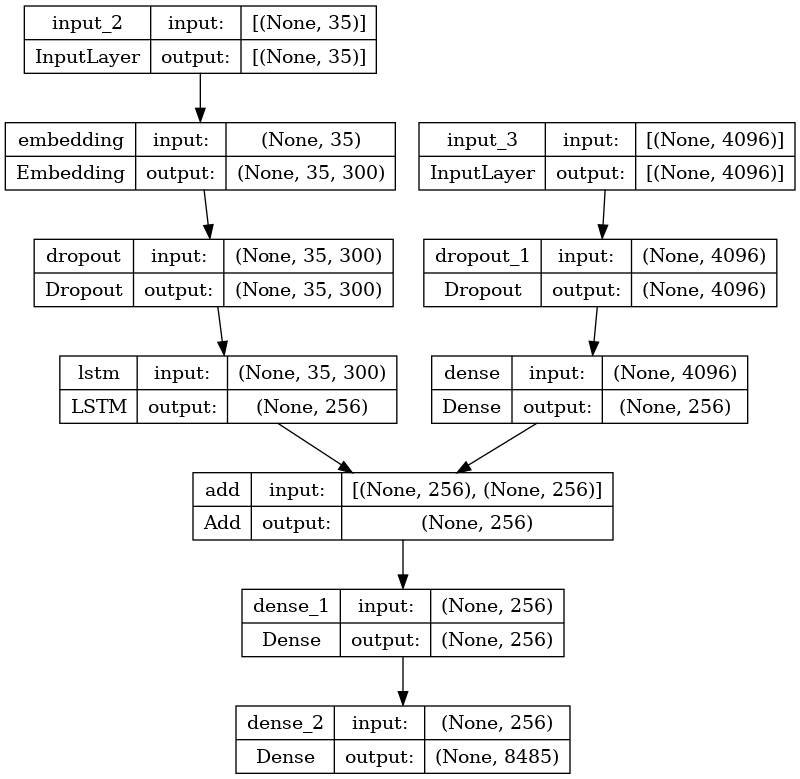

In [25]:
#sequence feature layers
input_1=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False,mask_zero=True)(input_1)
dropout_1=Dropout(0.4)(embedding_1)
lstm_1=LSTM(256)(dropout_1)

#image feature layers
input_2=Input(shape=(4096,))
dropout_2=Dropout(0.4)(input_2)
dense_1=Dense(256,activation='relu')(dropout_2)

#main model
add_1=add([lstm_1,dense_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_2,input_1],outputs=dense_3)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True)

In [26]:
epochs=10
batch_size=32
steps=len(train) // batch_size

for i in range(epochs):
    generator=data_generator(train,imgcap_map,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

model.save(output_dir+'/image_captioning.h5')

227/227 [==============================] - 70s 306ms/step - loss: 2.9218


In [27]:
pickle.dump(tokenizer,open(os.path.join(output_dir,'tokenizer.pkl'),'wb'))
pickle.dump(embeddings,open(os.path.join(output_dir,'embeddings.pkl'),'wb'))

## Generate Captions for the image

In [29]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
def top_k_sampling(prediction, k=5):
    top_indices = np.argsort(prediction)[-k:]  
    top_probs = prediction[top_indices]
    top_probs = top_probs / np.sum(top_probs)
    chosen_index = np.random.choice(top_indices, p=top_probs) 
    return chosen_index

def predict_captions(model,image,tokenizer,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0] #doubt
        sequence=pad_sequences([sequence],maxlen=max_length) #doubt
        prediction=model.predict([image,sequence],verbose=0)
        chosen_index = top_k_sampling(prediction[0])
        word=idx_to_word(chosen_index,tokenizer)
        if word is None:
            break
        in_text+=" "+word
        if word=="endseq":
            break
    return in_text

In [31]:
# for i in range(4096):
#     print(features['280706862_14c30d734a'])
print(features['1019604187_d087bf9a5f'])

[[0. 0. 0. ... 0. 0. 0.]]


In [34]:
from nltk.translate.bleu_score import corpus_bleu

actual,predicted=list(),list()
for key in tqdm(test):
    captions=imgcap_map[key]
    y_pred=predict_captions(model,features[key],tokenizer,max_length)
    actual_captions=[caption.split() for caption in captions] #doubt
    actual.append(actual_captions)
    predicted.append(y_pred.split())
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.497948
BLEU-2: 0.252042


## Visualize the Results

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    img_path=os.path.join(input_dir,"Images",image_name)
    image=Image.open(img_path)
    captions=imgcap_map[image_id]
    print("------------ACTUAL-----------")
    for caption in captions:
        print(caption)
    y_pred=predict_captions(model,features[image_id],tokenizer,max_length)
    print("----------PREDICTION---------")
    print(y_pred)
    plt.imshow(image)

------------ACTUAL-----------
startseq big brown dog is jumping in the water and has his mouth wide open endseq
startseq brown dog barks over its shoulder in the water endseq
startseq dog jumping in the water at beack endseq
startseq dog runs through the water as he looks up at the sky with his mouth open endseq
startseq dog with collar running through the water endseq
----------PREDICTION---------
startseq dog running across the ocean endseq


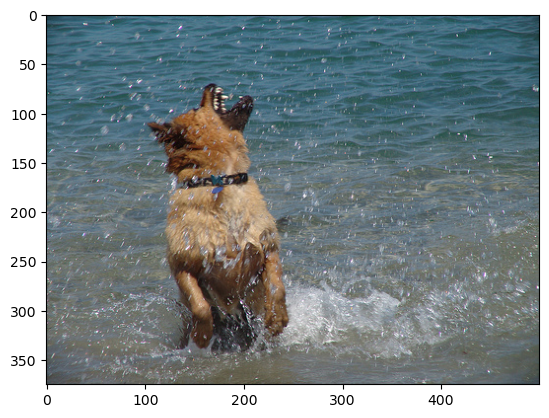

In [36]:
generate_caption("1287982439_6578006e22.jpg")

------------ACTUAL-----------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
----------PREDICTION---------
startseq woman with brown dog lies on the back of bench endseq


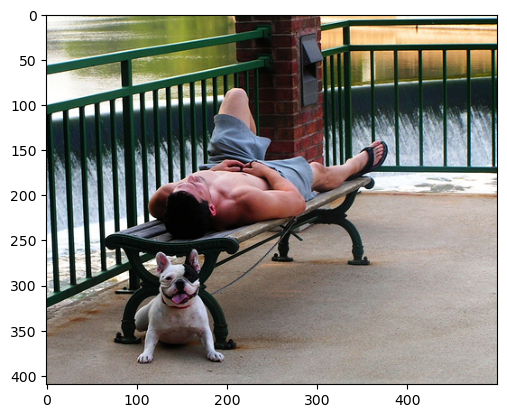

In [37]:
generate_caption("1003163366_44323f5815.jpg")

------------ACTUAL-----------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
----------PREDICTION---------
startseq girl grips ropes in gym gym endseq


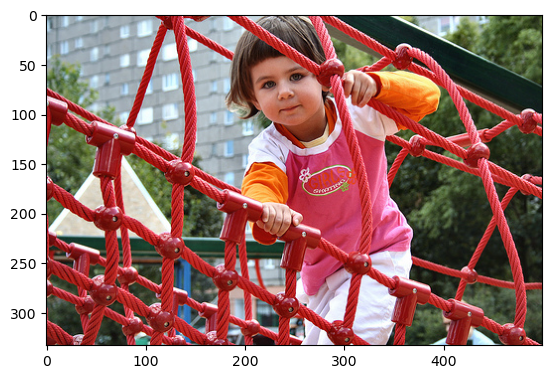

In [38]:
generate_caption("1007320043_627395c3d8.jpg")

------------ACTUAL-----------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
----------PREDICTION---------
startseq two dogs are running through the grass endseq


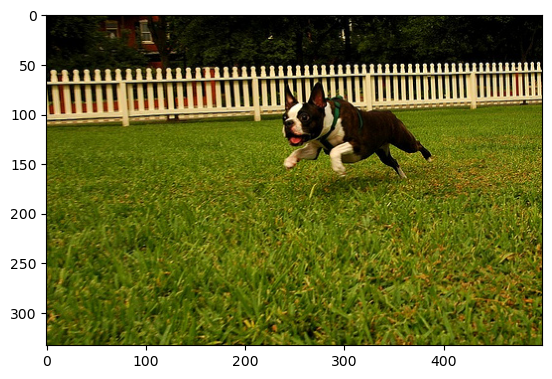

In [39]:
generate_caption("1009434119_febe49276a.jpg")

------------ACTUAL-----------
startseq girl in pigtails splashes in the shallow water endseq
startseq girls plays in the surf endseq
startseq girl with pigtails is playing in the ocean by the beach endseq
startseq girl with pigtails plays in the water endseq
startseq young girl in pigtails plays in the water endseq
----------PREDICTION---------
startseq young girl wearing black hair rides his hair while sprays into the beach endseq


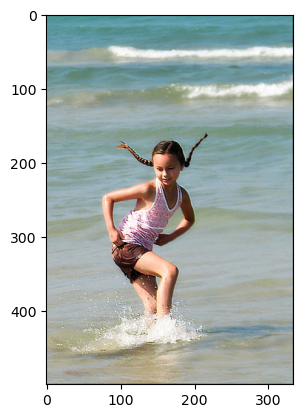

In [40]:
generate_caption("1053804096_ad278b25f1.jpg")

------------ACTUAL-----------
startseq "a dog shakes its head near the shore red ball next to it ." endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq "dog with orange ball at feet stands on shore shaking off water" endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
----------PREDICTION---------
startseq two dogs are walking through the sand endseq


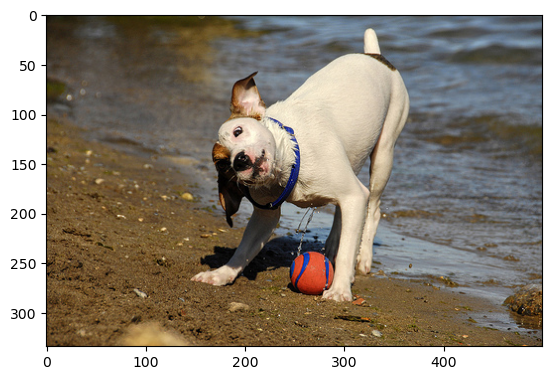

In [41]:
generate_caption("1012212859_01547e3f17.jpg")

------------ACTUAL-----------
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq
----------PREDICTION---------
startseq the dog jumps in its air in the woods endseq


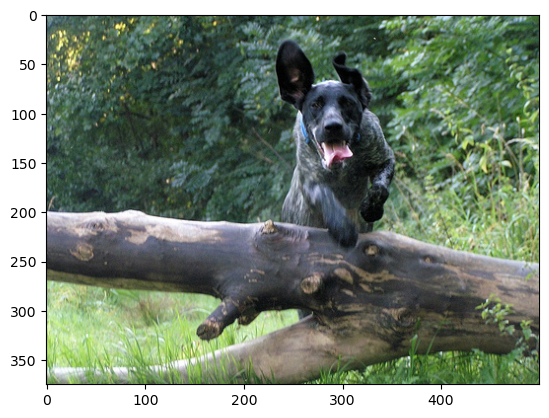

In [44]:
generate_caption("1015584366_dfcec3c85a.jpg")

------------ACTUAL-----------
startseq collage of one person climbing cliff endseq
startseq group of people are rock climbing on rock climbing wall endseq
startseq group of people climbing rock while one man belays endseq
startseq seven climbers are ascending rock face whilst another man stands holding the rope endseq
startseq several climbers in row are climbing the rock while the man in red watches and holds the line endseq
----------PREDICTION---------
startseq man climbing rock while another man watches another endseq


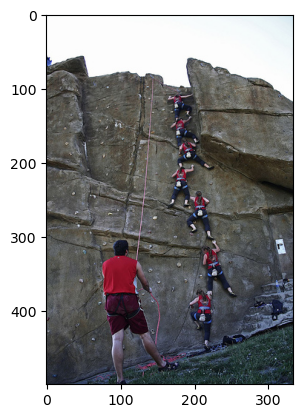

In [45]:
generate_caption("1016887272_03199f49c4.jpg")

------------ACTUAL-----------
startseq dog prepares to catch thrown object in field with nearby cars endseq
startseq white dog is about to catch yellow ball in its mouth endseq
startseq white dog is about to catch yellow dog toy endseq
startseq white dog is ready to catch yellow ball flying through the air endseq
startseq white dog running after yellow ball endseq
----------PREDICTION---------
startseq two dogs in field yard in yard endseq


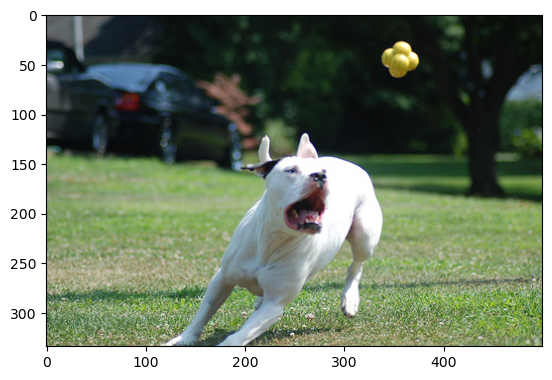

In [46]:
generate_caption("1019604187_d087bf9a5f.jpg")

------------ACTUAL-----------
startseq black and white dog jumping in the air to get toy endseq
startseq black and white dog jumps up towards yellow toy endseq
startseq dog leaps to catch ball in field endseq
startseq white dog is trying to catch ball in midair over grassy field endseq
startseq the white dog is playing in green field with yellow toy endseq
----------PREDICTION---------
startseq white dog is jumping on green grass with red object endseq


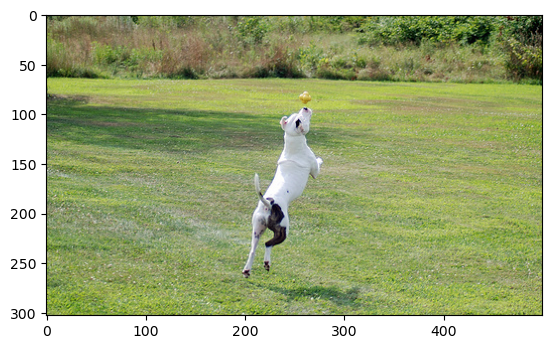

In [47]:
generate_caption("1020651753_06077ec457.jpg")

------------ACTUAL-----------
startseq "a couple and an infant being held by the male sitting next to pond with near by stroller ." endseq
startseq couple sit on the grass with baby and stroller endseq
startseq couple with their newborn baby sitting under tree facing lake endseq
startseq man and woman care for an infant along the side of body of water endseq
startseq couple with baby sit outdoors next to their stroller endseq
----------PREDICTION---------
startseq woman wearing glasses and scarf is sitting in front of crowd and people on the side of the camera endseq


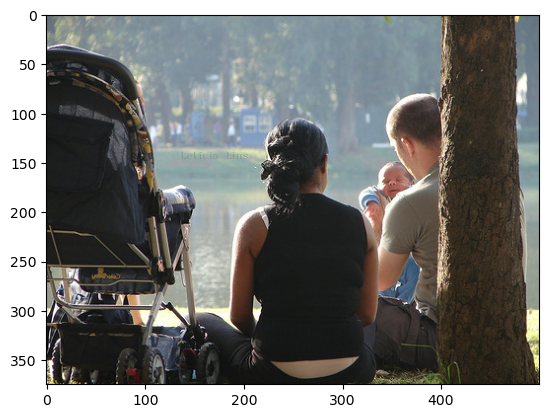

In [48]:
generate_caption("1022454428_b6b660a67b.jpg")

------------ACTUAL-----------
startseq black dog running in the surf endseq
startseq black lab with tags frolicks in the water endseq
startseq dog splashes in the water endseq
startseq the black dog runs through the water endseq
startseq this is black dog splashing in the water endseq
----------PREDICTION---------
startseq black lab dog carries toy in the ocean endseq


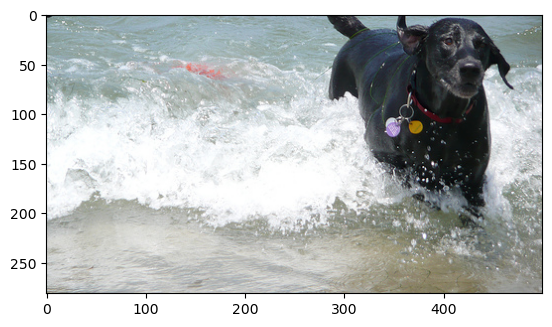

In [49]:
generate_caption("1022975728_75515238d8.jpg")

------------ACTUAL-----------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
----------PREDICTION---------
startseq man is drilling on the snow with lake in the ocean endseq


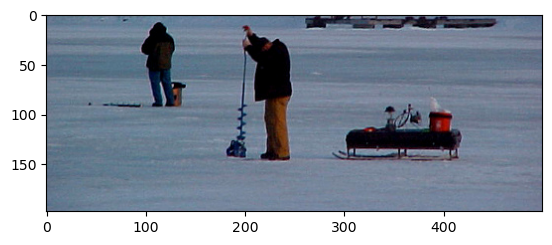

In [50]:
generate_caption("102351840_323e3de834.jpg")

------------ACTUAL-----------
startseq brown dog chases the water from sprinkler on lawn endseq
startseq brown dog plays with the hose endseq
startseq brown dog running on lawn near garden hose endseq
startseq dog is playing with hose endseq
startseq large brown dog running away from the sprinkler in the grass endseq
----------PREDICTION---------
startseq dog is running through the grass endseq


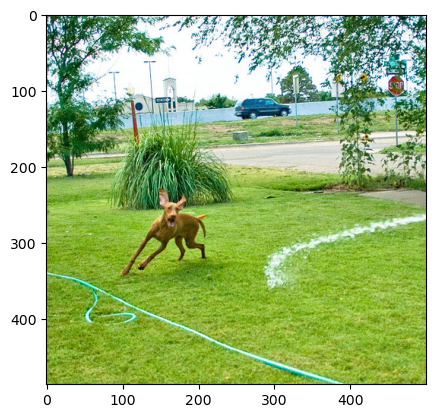

In [51]:
generate_caption("1019077836_6fc9b15408.jpg")

------------ACTUAL-----------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
----------PREDICTION---------
startseq two people in red pants are standing on hill endseq


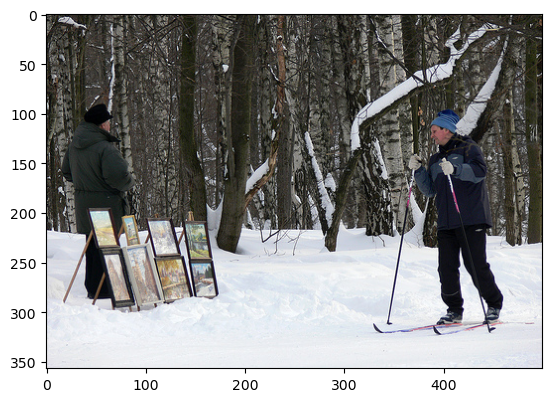

In [57]:
generate_caption("101669240_b2d3e7f17b.jpg")